In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from zipfile import ZipFile

In [3]:
with ZipFile('/content/FruitinAmazon.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
# Define dataset path
train_dir = "/content/FruitinAmazon/train"
test_dir ="/content/FruitinAmazon/test"


In [5]:
import os
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [6]:

corrupted_images = []  # List to store corrupted image paths

# Loop through each class folder and check for corrupted images
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a valid directory
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

# Print results
if corrupted_images:
    print("\nCorrupted Images Found:")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")



No corrupted images found.


In [7]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)



Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


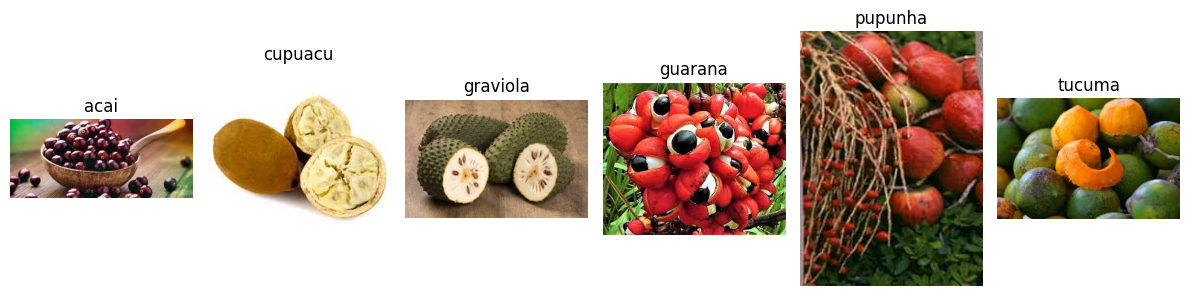

In [8]:

selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

num_classes = len(selected_images)
fig, axes = plt.subplots(1,num_classes, figsize=(12,6))

if num_classes == 1:
    axes = [axes]

for ax, img_path, label in zip(axes, selected_images, selected_labels):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [9]:
# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 64


# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Verify class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")




Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6


In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [11]:
from tensorflow.keras.layers import LeakyReLU

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    for filters in [32, 64, 128, 256]:
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.15)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = make_model(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             

 Total params: 491,334 (1.87 MB)

 Trainable params: 489,606 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_task1.h5', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train
history = model.fit(
    train_ds,
    epochs=250,
    batch_size = batch_size,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1648 - loss: 2.1287  

2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.1728 - loss: 2.1163 - val_accuracy: 0.2000 - val_loss: 1.7887
Epoch 2/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.3003 - loss: 1.8148 - val_accuracy: 0.1667 - val_loss: 1.7863
Epoch 3/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3240 - loss: 1.6612  

2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.3382 - loss: 1.6435 - val_accuracy: 0.2333 - val_loss: 1.7807
Epoch 4/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.3799 - loss: 1.5865 - val_accuracy: 0.2000 - val_loss: 1.7720
Epoch 5/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.4666 - loss: 1.5107 - val_accuracy: 0.2000 - val_loss: 1.7692
Epoch 6/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.4317 - loss: 1.4850 - val_accuracy: 0.2333 - val_loss: 1.7610
Epoch 7/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4609 - loss: 1.3495  

2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.4740 - loss: 1.3265 - val_accuracy: 0.3000 - val_loss: 1.7559
Epoch 8/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.4822 - loss: 1.2894 - val_accuracy: 0.1667 - val_loss: 1.7637
Epoch 9/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.5230 - loss: 1.2873 - val_accuracy: 0.2333 - val_loss: 1.7801
Epoch 10/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.6231 - loss: 1.1302 - val_accuracy: 0.2333 - val_loss: 1.8038
Epoch 11/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.6053 - loss: 1.1370 - val_accuracy: 0.2667 - val_loss: 1.8134
Epoch 12/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.6632 - loss: 0.9547 - val_accuracy: 0.3000 - val_loss: 1.8112
Epoch 13/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.6179 - loss: 1.0589 - val_accuracy: 0.3000 - val_loss: 1.8014


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2667 - loss: 1.7576
Test accuracy: 0.2667
Test loss: 1.7576


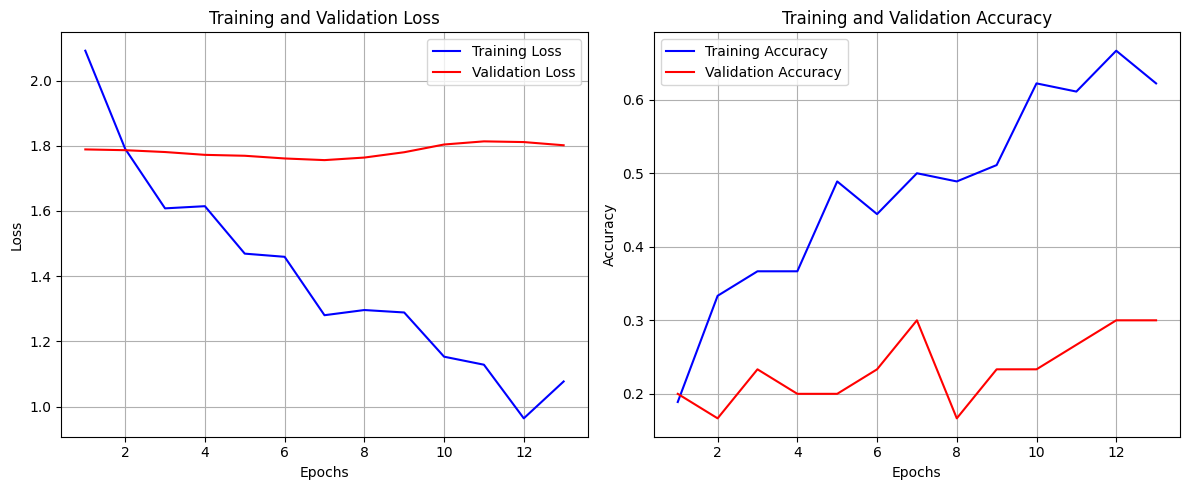

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


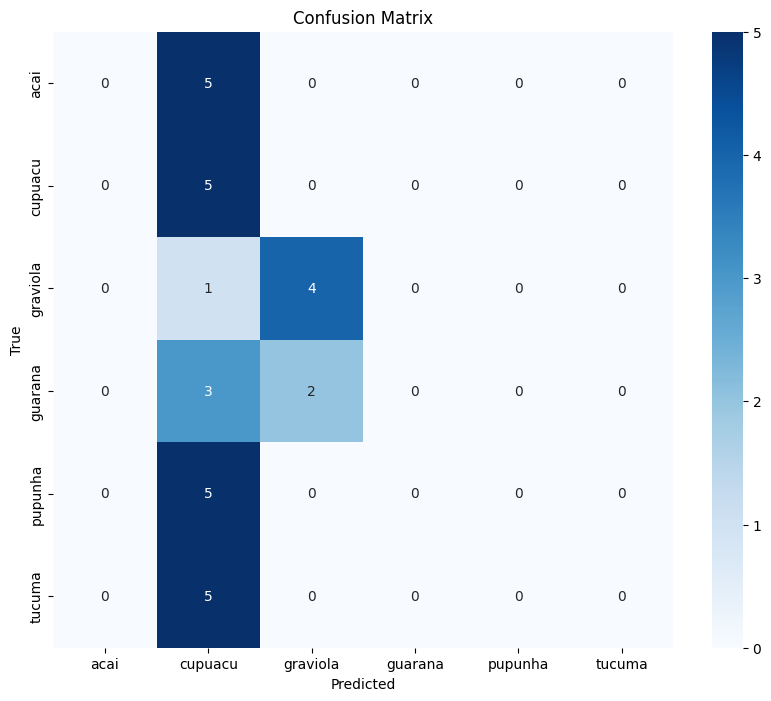

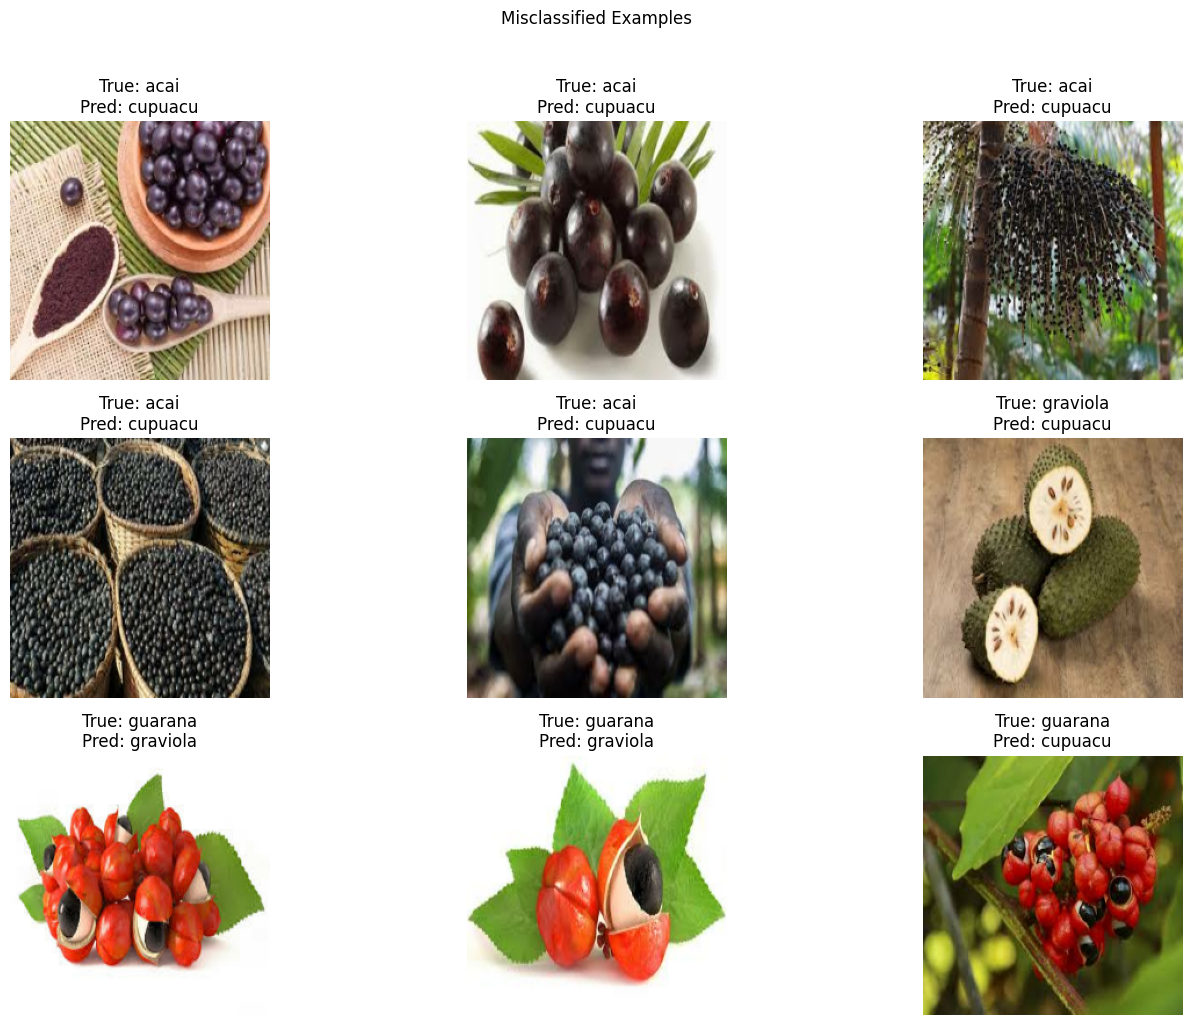

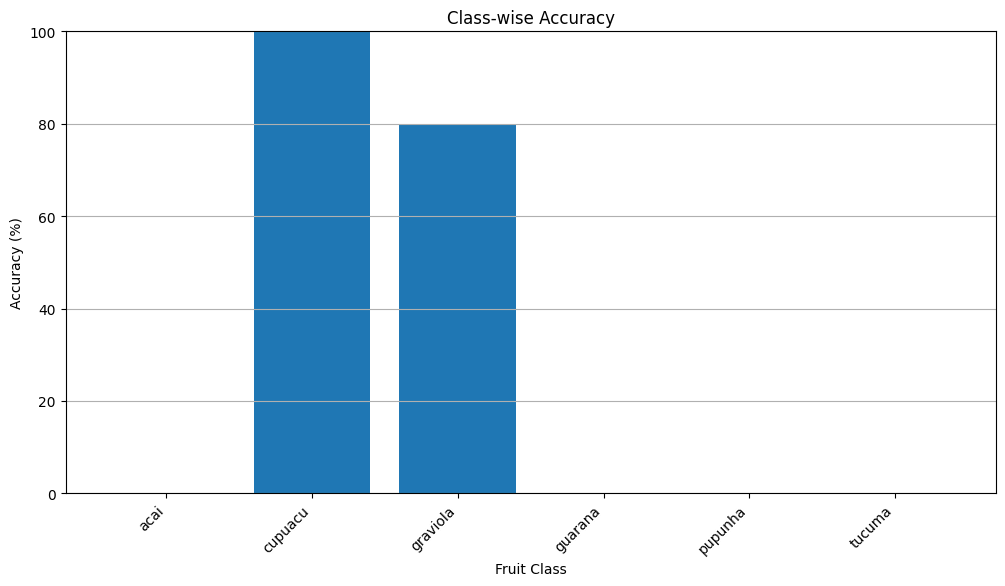

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Training history plots
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
# STEP 1: Extract images and labels from test_ds
test_images_list = []
test_labels_list = []

for images, labels in test_ds:
    test_images_list.append(images.numpy())
    test_labels_list.append(labels.numpy())

test_images = np.concatenate(test_images_list)
test_labels = np.concatenate(test_labels_list)

# STEP 2: Predict on test images
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

# STEP 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# STEP 4: Misclassified Examples
misclassified_idx = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idx[:9]):  # Show first 9 misclassified
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[idx].astype("uint8"))
    plt.title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred_classes[idx]]}')
    plt.axis('off')
plt.suptitle('Misclassified Examples', y=1.02)
plt.tight_layout()
plt.show()

# STEP 5: Class-wise Accuracy Bar Chart
class_accuracy = 100 * cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(12, 6))
plt.bar(range(len(class_names)), class_accuracy)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.xlabel('Fruit Class')
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Accuracy')
plt.ylim([0, 100])
plt.grid(axis='y')
plt.show()


In [19]:
model.save('KrisamByanju_worksheet5_task1.h5')
print("Model saved as 'KrisamByanju_worksheet5_task1.h5'")

Model saved as 'KrisamByanju_worksheet5_task1.h5'


Task2

In [22]:

loaded_model = tf.keras.models.load_model('KrisamByanju_worksheet5_task1.h5')
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3000 - loss: 1.7559
Loaded model test accuracy: 0.3000
Loaded model test loss: 1.7559


In [24]:
loaded_model = keras.models.load_model('KrisamByanju_worksheet5_task1.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)


print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.21      1.00      0.34         5
    graviola       0.67      0.80      0.73         5
     guarana       0.00      0.00      0.00         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.00      0.00      0.00         5

    accuracy                           0.30        30
   macro avg       0.15      0.30      0.18        30
weighted avg       0.15      0.30      0.18        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_vgg = keras.Model(inputs=base_model.input, outputs=outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [26]:
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_vgg = model_vgg.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=[ModelCheckpoint('best_model_task2.h5', monitor='val_accuracy', save_best_only=True),
               EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.1491 - loss: 5.8853 

2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 35s/step - accuracy: 0.1624 - loss: 5.9367 - val_accuracy: 0.4333 - val_loss: 7.9189
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 34s/step - accuracy: 0.5541 - loss: 5.9847 - val_accuracy: 0.4333 - val_loss: 6.4142
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7717 - loss: 3.1957 

2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 29s/step - accuracy: 0.7737 - loss: 3.1543 - val_accuracy: 0.5667 - val_loss: 3.2110
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9220 - loss: 0.6168 

2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 29s/step - accuracy: 0.9221 - loss: 0.6124 - val_accuracy: 0.6000 - val_loss: 3.0601
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 30s/step - accuracy: 0.9525 - loss: 0.2063 - val_accuracy: 0.5333 - val_loss: 6.8589
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 29s/step - accuracy: 0.8568 - loss: 0.6906 - val_accuracy: 0.4667 - val_loss: 6.1431
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 91s 34s/step - accuracy: 0.9622 - loss: 0.0585 - val_accuracy: 0.4667 - val_loss: 4.5581
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 34s/step - accuracy: 0.9874 - loss: 0.0388 - val_accuracy: 0.5333 - val_loss: 4.0556
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 34s/step - accuracy: 0.9800 - loss: 0.0349 - val_accuracy: 0.5333 - val_loss: 3.8287
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 81s 34s/step - accuracy: 0.9926 - loss: 0.0276 - val_accuracy: 0.5000 - val_loss: 3.5432
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 81s 34s/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.5667 - val_loss: 3.3636
Epoch 12/

In [27]:
# Evaluate
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_ds)
print(f"Test accuracy for VGG16: {test_acc_vgg:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.6000 - loss: 3.0601
Test accuracy for VGG16: 0.6000


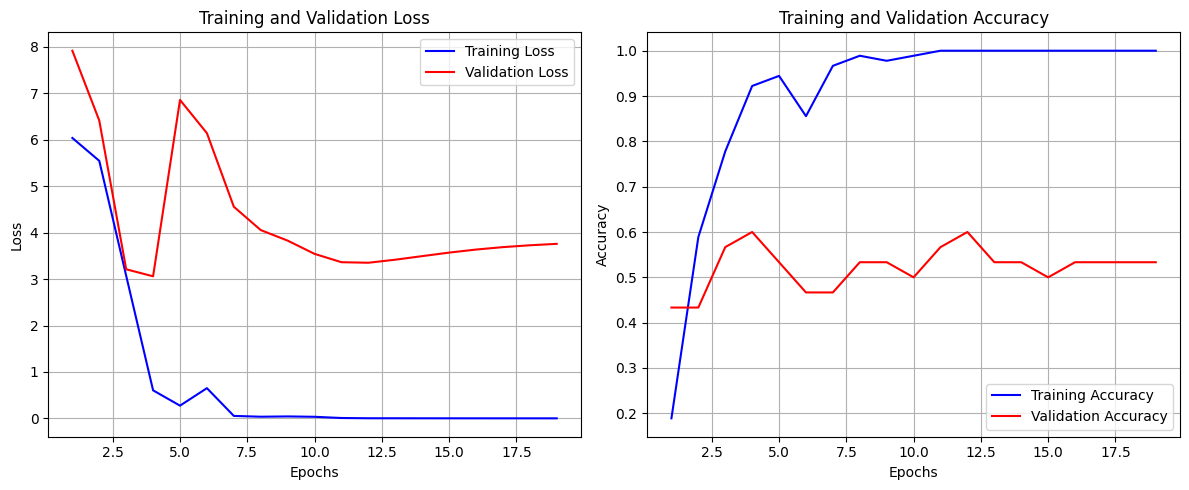

In [28]:
history_dict = history_vgg.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
model.save('task2.h5')
print("Model saved as 'task2.h5'")

In [30]:

predictions_vgg = model_vgg.predict(test_ds)
y_pred_vgg = np.argmax(predictions_vgg, axis=1)

# Classification Report
print("Classification Report for Task 2 (VGG16):")
print(classification_report(true_labels, y_pred_vgg, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Classification Report for Task 2 (VGG16):
              precision    recall  f1-score   support

        acai       0.57      0.80      0.67         5
     cupuacu       0.50      0.60      0.55         5
    graviola       1.00      0.80      0.89         5
     guarana       1.00      0.80      0.89         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.33      0.60      0.43         5

    accuracy                           0.60        30
   macro avg       0.57      0.60      0.57        30
weighted avg       0.57      0.60      0.57        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
